# Metadata unification

Since the metadata of the datasets are not unified, it is necessary to unify them in order to be able to use them in the same way. Since this is the only year in the dataset, it doesn't make sense to try to create a python script to do this,

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt
import random
from PIL import Image
from melanoma_segmentation.datasets.image_data import ImageDataset
from melanoma_segmentation.configs import CONFIG

c:\Users\user\Deep Learning\melanoma-segmentation-and-classification\.venv\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Metadata extraction

In [3]:
# Classification_GroundTruth

gt_training = pd.read_csv('../data/ISIC-2017_Training_Part3_GroundTruth.csv')
gt_validation = pd.read_csv('../data/ISIC-2017_Validation_Part3_GroundTruth.csv')

# Classification_Metadata
gt_training_metadata = pd.read_csv('../data/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv')
gt_validation_metadata = pd.read_csv('../data/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_metadata.csv')

## Image extraction

In [5]:
base_dir = '../data'
image_folder = CONFIG["image_folder"]
gt_folder = CONFIG["gt_folder"]
split_train = CONFIG["split_train"]
split_val = CONFIG["split_val"]
split_test = CONFIG["split_test"]
image_size = CONFIG["image_size"]

# Retrieve the image and ground truth paths
dataset_paths = ImageDataset(base_dir, image_folder, gt_folder)
print("Retrieving image and ground truth paths...")

image_paths, gt_paths = dataset_paths.get_image_and_gt_paths()
print("Image and ground truth paths retrieved.")
print("Number of images: ", len(image_paths))
print("Number of ground truths: ", len(gt_paths))

Retrieving image and ground truth paths...
Image and ground truth paths retrieved.
Number of images:  2000
Number of ground truths:  2000


## Image examples



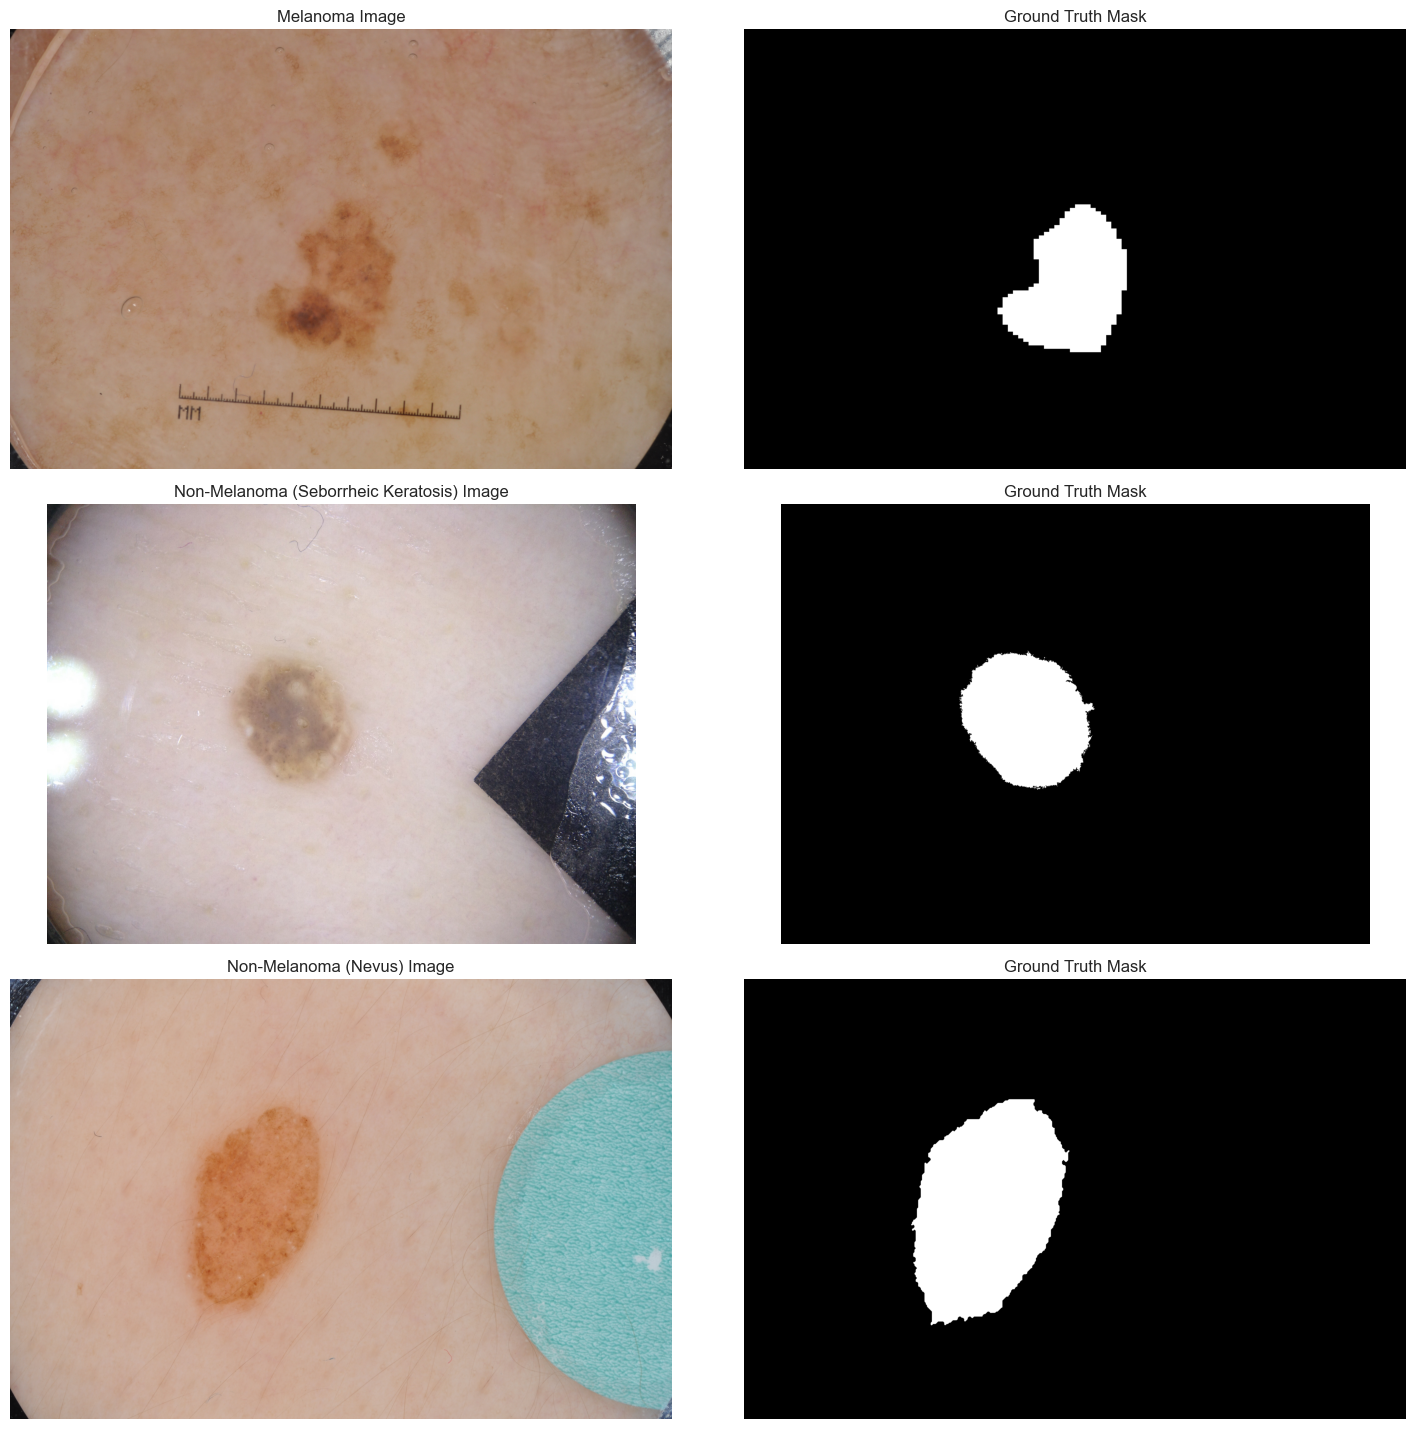

In [27]:
def display_specific_examples(image_paths, gt_paths, metadata, categories=["melanoma", "seborrheic_keratosis", "nevus"], num_examples=1):
    """
    Displays examples of images and their ground truth masks for specified categories.

    Parameters:
    - image_paths: List of image file paths.
    - gt_paths: List of ground truth mask file paths.
    - metadata: DataFrame containing metadata about the images.
    - categories: List of categories to display ("melanoma", "seborrheic_keratosis", "nevus").
    - num_examples: Number of examples per category.
    """
    fig, axes = plt.subplots(len(categories), 2 * num_examples, figsize=(15, 5 * len(categories)))

    for row, category in enumerate(categories):
        # Filter metadata for the category
        if category == "melanoma":
            filtered_metadata = metadata[metadata["melanoma"] == 1]
            label = "Melanoma"
        elif category == "seborrheic_keratosis":
            filtered_metadata = metadata[metadata["seborrheic_keratosis"] == 1]
            label = "Non-Melanoma (Seborrheic Keratosis)"
        elif category == "nevus":
            filtered_metadata = metadata[(metadata["melanoma"] == 0) & (metadata["seborrheic_keratosis"] == 0)]
            label = "Non-Melanoma (Nevus)"
        else:
            continue

        # Select random examples from the filtered metadata
        selected_images = filtered_metadata.sample(n=num_examples, random_state=42)

        for col, (_, row_data) in enumerate(selected_images.iterrows()):
            image_id = row_data["image_id"]
            # Find the image and mask paths
            image_path = next((p for p in image_paths if image_id in p), None)
            gt_path = next((p for p in gt_paths if image_id in p), None)

            if image_path and gt_path:
                image = Image.open(image_path)
                mask = Image.open(gt_path)

                # Display image
                axes[row, 2 * col].imshow(image, cmap="gray")
                axes[row, 2 * col].set_title(f"{label} Image")
                axes[row, 2 * col].axis("off")

                # Display ground truth mask
                axes[row, 2 * col + 1].imshow(mask, cmap="gray")
                axes[row, 2 * col + 1].set_title("Ground Truth Mask")
                axes[row, 2 * col + 1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Display examples for melanoma, seborrheic keratosis, and nevus
display_specific_examples(image_paths, gt_paths, metadata, categories=["melanoma", "seborrheic_keratosis", "nevus"], num_examples=1)


## Get image distribution

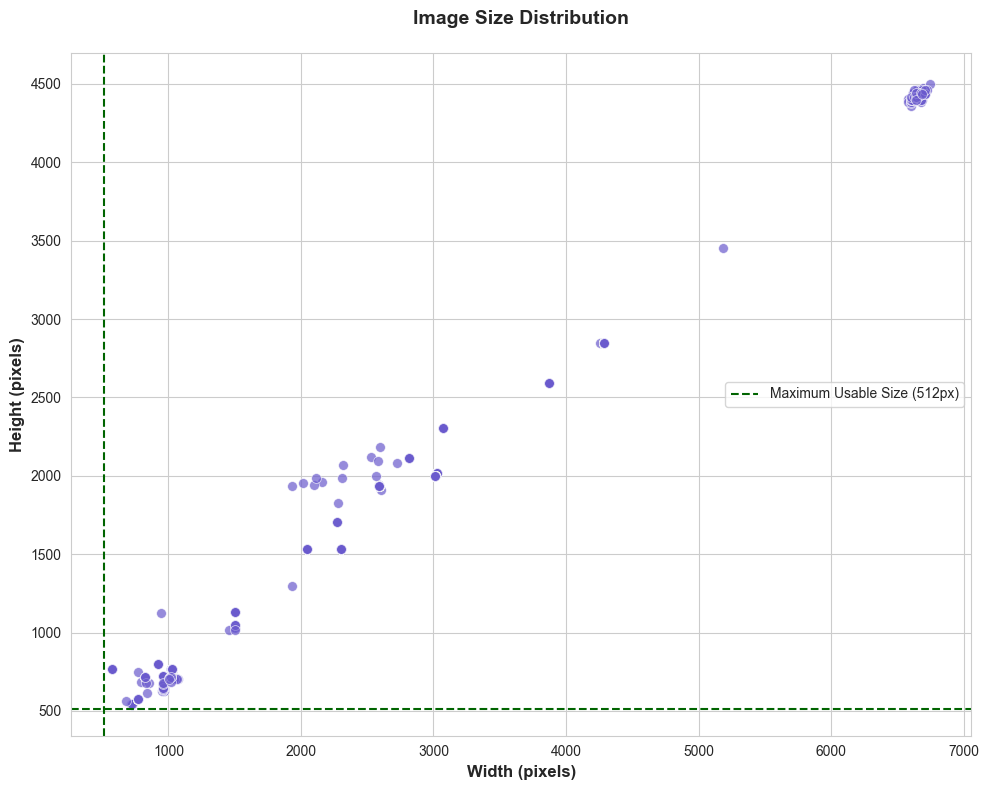

In [20]:
def plot_image_size_distribution_with_max(image_paths, target_size=256, max_size=512):
    sizes = []
    for path in image_paths:
        with Image.open(path) as img:
            sizes.append(img.size)  # (width, height)

    widths, heights = zip(*sizes)

    # Use Seaborn to enhance visuals
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 8))

    # Scatter plot with a new color palette
    sns.scatterplot(x=widths, y=heights, alpha=0.7, color="slateblue", s=50)

    
    # Max size lines
    plt.axhline(y=max_size, color='darkgreen', linestyle='--', linewidth=1.5, label=f"Maximum Usable Size ({max_size}px)")
    plt.axvline(x=max_size, color='darkgreen', linestyle='--', linewidth=1.5)

    # Labels and title
    plt.xlabel("Width (pixels)", fontsize=12, weight="bold")
    plt.ylabel("Height (pixels)", fontsize=12, weight="bold")
    plt.title("Image Size Distribution\n", 
              fontsize=14, weight="bold")
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Plot image size distribution with max size and target size
plot_image_size_distribution_with_max(image_paths, target_size=256, max_size=512)


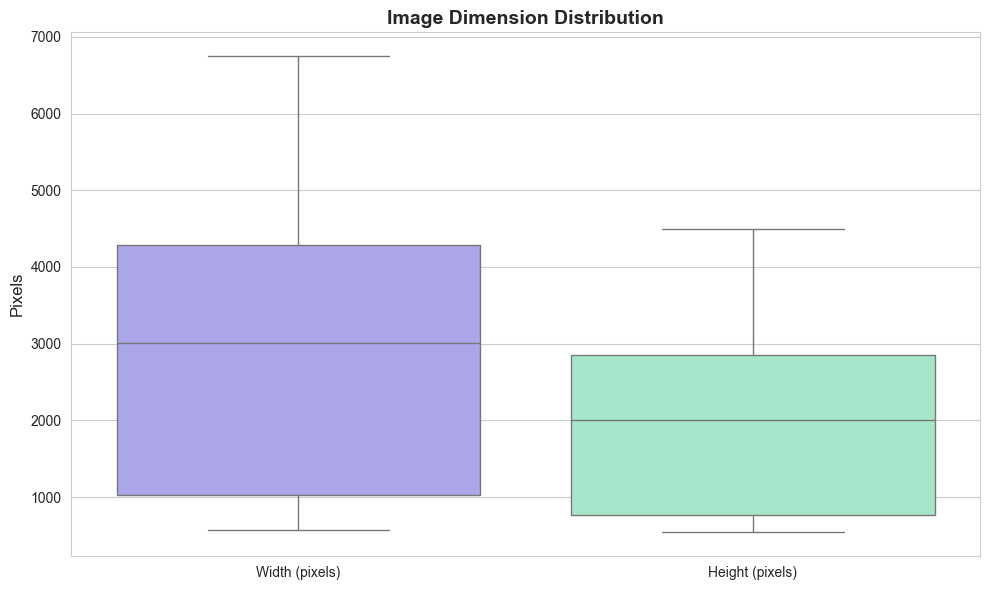

In [28]:
def plot_image_size_boxplot(image_paths):
    sizes = []
    for path in image_paths:
        with Image.open(path) as img:
            sizes.append(img.size)  # (width, height)

    # Prepare data for Seaborn boxplot
    widths, heights = zip(*sizes)
    data = {
        "Width (pixels)": widths,
        "Height (pixels)": heights
    }

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Box plot with a new color palette
    sns.boxplot(data=data, palette=["#a29bf2", "#9bf2cc"])
    plt.title("Image Dimension Distribution", fontsize=14, weight="bold")
    plt.ylabel("Pixels", fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot boxplot for image sizes
plot_image_size_boxplot(image_paths)


## Generate Pandas Profiling Report

In [18]:
gt_training_discovery = gt_training.merge(gt_training_metadata, on='image_id')
gt_validation_discovery = gt_training.merge(gt_training_metadata, on='image_id')

# # Generate a profile report of the data
# def generate_profile_report(data, name):
#     #Extract name from variable

#     profile = pandas_profiling.ProfileReport(data)
#     profile.to_file(f"profile_report_{name}.html")

# generate_profile_report(gt_training_discovery, 'training')
# generate_profile_report(gt_validation_discovery, 'validation')

Due to the nature of the training, it is not possible to leave the unknown values as they are. This may cause the model to be trained incorrectly. Therefore, it is necessary to make a decision about the unknown values. In this case, the unknown values will be deleted.

In [19]:
#Filter metadata of any 'unknown' in age_approximate or sex
gt_training_metadata['age_approximate'] = gt_training_metadata['age_approximate'].replace('unknown', '0')
gt_validation_metadata['age_approximate'] = gt_validation_metadata['age_approximate'].replace('unknown', '0')

#Filter all unknowns from sex
gt_training_metadata = gt_training_metadata[gt_training_metadata['sex'] != 'unknown']
gt_validation_metadata = gt_validation_metadata[gt_validation_metadata['sex'] != 'unknown']

#Cast age_approximate to int as well as melanoma
gt_training_metadata['age_approximate'] = round(gt_training_metadata['age_approximate'].astype(int))
gt_validation_metadata['age_approximate'] = round(gt_validation_metadata['age_approximate'].astype(int))
gt_training['melanoma'] = gt_training['melanoma'].astype(int)
gt_validation['melanoma'] = gt_validation['melanoma'].astype(int)

In [20]:
#Join left on gt_training_metadata
gt_training_merged = gt_training.merge(gt_training_metadata, how='right', on='image_id')
gt_validation_merged = gt_validation.merge(gt_validation_metadata, how='right', on='image_id')

In [21]:
#Check if dimensions are correct
print(gt_training.shape)
print(gt_validation.shape)

print(gt_training_metadata.shape)
print(gt_validation_metadata.shape)

print(gt_training_merged.shape)
print(gt_validation_merged.shape)


(2000, 3)
(150, 3)
(1771, 3)
(149, 3)
(1771, 5)
(149, 5)


In [22]:
#Delete columns that are not needed (seborrheic_keratosis)
gt_training_merged = gt_training_merged.drop(['seborrheic_keratosis'], axis=1)
gt_validation_merged = gt_validation_merged.drop(['seborrheic_keratosis'], axis=1)

#Check if columns are deleted
print(gt_training_merged.shape)
print(gt_validation_merged.shape)

(1771, 4)
(149, 4)


In [23]:
gt_training_merged.head()

,image_id,melanoma,age_approximate,sex
0,ISIC_0000000,0,55,female
1,ISIC_0000001,0,30,female
2,ISIC_0000002,1,60,female
3,ISIC_0000003,0,30,male
4,ISIC_0000004,1,80,male


In [24]:
#Export to csv the final datasets
gt_training_merged.to_csv('../data/metadata/ISIC-2017_Training_Data.csv', index=False)
gt_validation_merged.to_csv('../data/metadata/ISIC-2017_Validation_Data.csv', index=False)

## Data exploration

In [25]:
# Analyze distributions
def analyze_and_plot(df, dataset_name):
    print(f"--- Analysis for {dataset_name} ---")
    print(df.describe(include='all'))

analyze_and_plot(gt_training_merged, 'training')


--- Analysis for training ---
            image_id     melanoma  age_approximate   sex
count           1771  1771.000000      1771.000000  1771
unique          1771          NaN              NaN     2
top     ISIC_0000000          NaN              NaN  male
freq               1          NaN              NaN   900
mean             NaN     0.177866        48.286279   NaN
std              NaN     0.382508        20.481821   NaN
min              NaN     0.000000         0.000000   NaN
25%              NaN     0.000000        35.000000   NaN
50%              NaN     0.000000        50.000000   NaN
75%              NaN     0.000000        65.000000   NaN
max              NaN     1.000000        85.000000   NaN


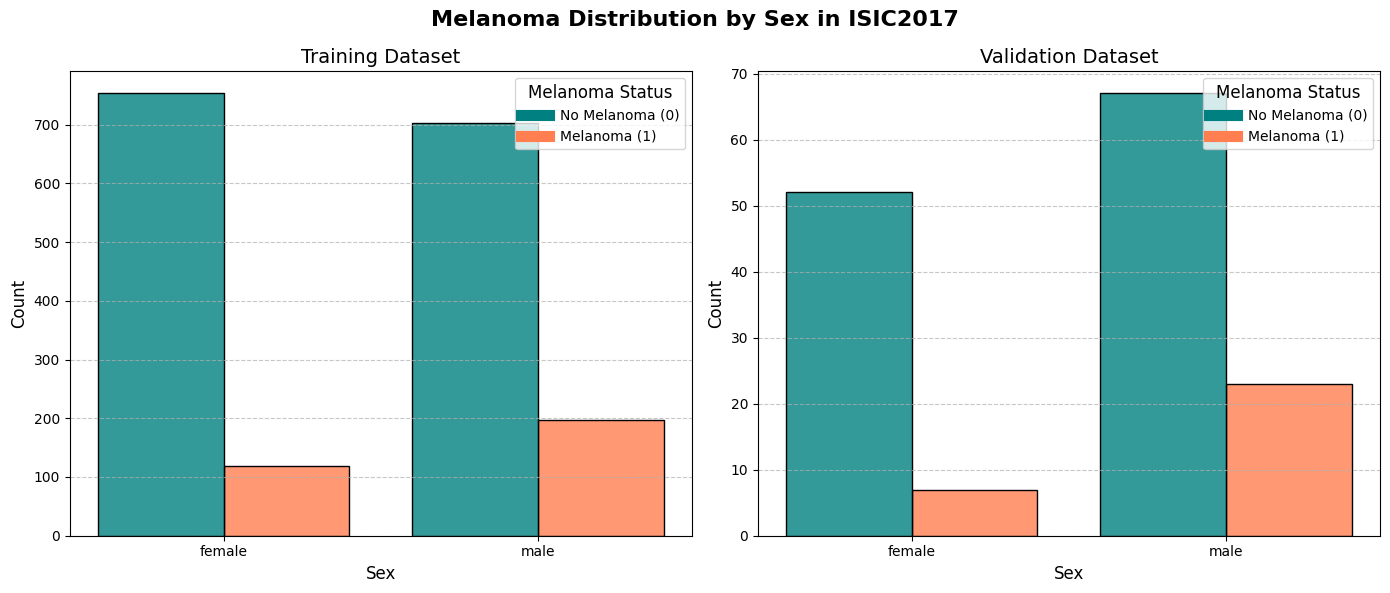

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of 'melanoma'
def plot_melanoma_distribution():
    # Define consistent colors for melanoma statuses
    custom_palette = {0: 'teal', 1: 'coral'}  # Teal for No Melanoma, Coral for Melanoma

    # Create separate plots for training and validation datasets
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjusted size to match age distribution plots
    fig.suptitle('Melanoma Distribution by Sex in ISIC2017', fontsize=16, weight='bold')
    # Training Dataset
    sns.histplot(
        data=gt_training_merged,
        x='sex',
        hue='melanoma',
        multiple="dodge",
        palette=custom_palette,
        shrink=0.8,
        alpha=0.8,  # Apply transparency
        ax=axes[0]
    )
    axes[0].set_title('Training Dataset', fontsize=14)
    axes[0].set_xlabel('Sex', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Manually set the legend
    axes[0].legend(
        handles=[
            plt.Line2D([0], [0], color='teal', lw=8, label='No Melanoma (0)'),
            plt.Line2D([0], [0], color='coral', lw=8, label='Melanoma (1)')
        ],
        title='Melanoma Status',
        fontsize=10,
        title_fontsize=12,
        loc='upper right',
        frameon=True
    )

    # Validation Dataset
    sns.histplot(
        data=gt_validation_merged,
        x='sex',
        hue='melanoma',
        multiple="dodge",
        palette=custom_palette,
        shrink=0.8,
        alpha=0.8,  # Apply transparency
        ax=axes[1]
    )
    axes[1].set_title('Validation Dataset', fontsize=14)
    axes[1].set_xlabel('Sex', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Manually set the legend
    axes[1].legend(
        handles=[
            plt.Line2D([0], [0], color='teal', lw=8, label='No Melanoma (0)'),
            plt.Line2D([0], [0], color='coral', lw=8, label='Melanoma (1)')
        ],
        title='Melanoma Status',
        fontsize=10,
        title_fontsize=12,
        loc='upper right',
        frameon=True
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_melanoma_distribution()


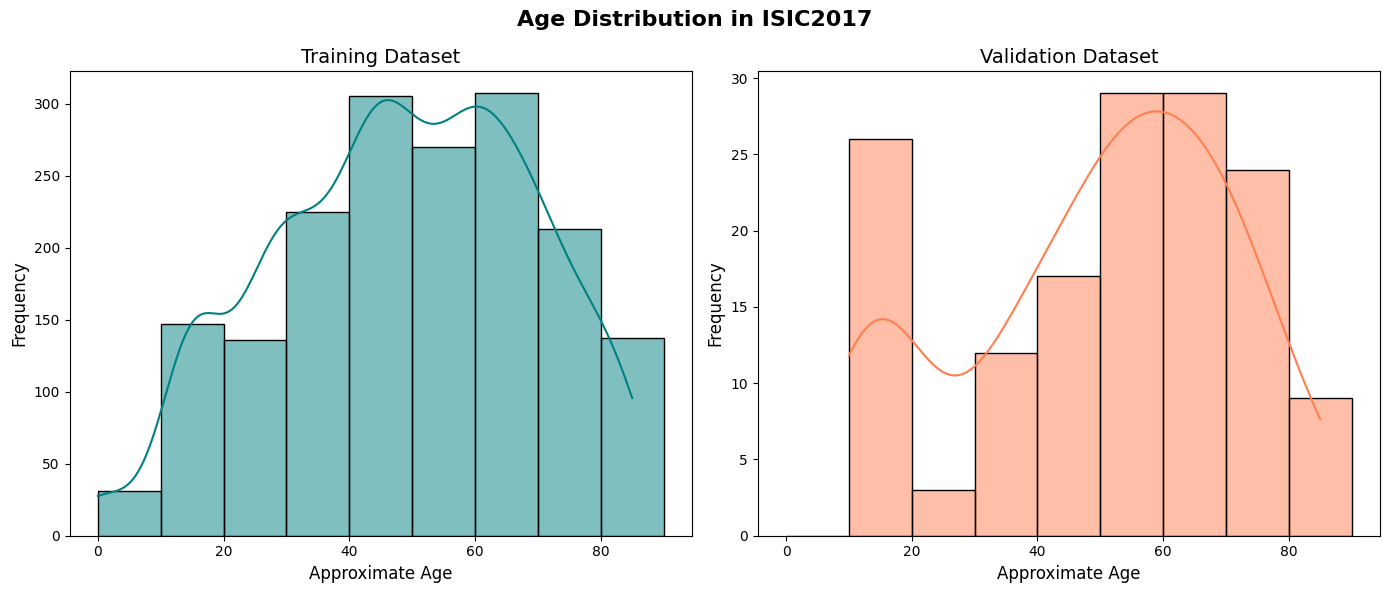

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the data is sorted numerically by age
gt_training_merged = gt_training_merged.sort_values(by='age_approximate')
gt_validation_merged = gt_validation_merged.sort_values(by='age_approximate')

# Define fixed intervals (bins) for the histogram
age_min = min(gt_training_merged['age_approximate'].min(), gt_validation_merged['age_approximate'].min())
age_max = max(gt_training_merged['age_approximate'].max(), gt_validation_merged['age_approximate'].max())
bins = np.arange(age_min - (age_min % 10), age_max + (10 - age_max % 10) + 10, 10)

# Distribution of 'age_approximate'
def plot_age_distribution():
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Age Distribution in ISIC2017', fontsize=16, weight='bold')
    
    # Training Dataset
    sns.histplot(data=gt_training_merged, x='age_approximate', kde=True, bins=bins, ax=ax[0], color='teal')
    ax[0].set_title('Training Dataset', fontsize=14)
    ax[0].set_xlabel('Approximate Age', fontsize=12)
    ax[0].set_ylabel('Frequency', fontsize=12)
    
    # Validation Dataset
    sns.histplot(data=gt_validation_merged, x='age_approximate', kde=True, bins=bins, ax=ax[1], color='coral')
    ax[1].set_title('Validation Dataset', fontsize=14)
    ax[1].set_xlabel('Approximate Age', fontsize=12)
    ax[1].set_ylabel('Frequency', fontsize=12)
    
    plt.tight_layout()
    plt.show()

plot_age_distribution()


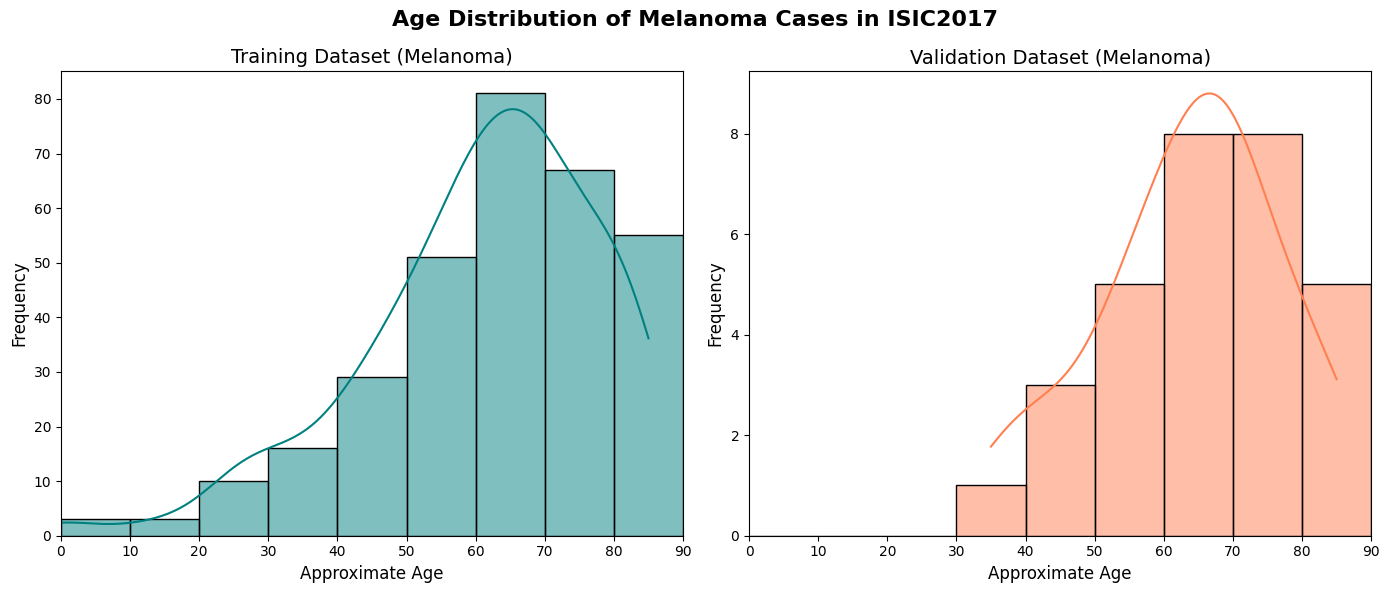

In [31]:
melanoma_training = gt_training_merged[gt_training_merged['melanoma'] == 1]
melanoma_validation = gt_validation_merged[gt_validation_merged['melanoma'] == 1]

# Get the common x-axis range
min_age = min(melanoma_training['age_approximate'].min(), melanoma_validation['age_approximate'].min())
max_age = max(melanoma_training['age_approximate'].max(), melanoma_validation['age_approximate'].max())

# Define fixed intervals (bins) of 10
bins = np.arange(min_age - (min_age % 10), max_age + (10 - max_age % 10) + 10, 10)

# Distribution of 'age_approximate' for melanoma cases
def plot_melanoma_age_distribution_scaled():
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Age Distribution of Melanoma Cases in ISIC2017', fontsize=16, weight='bold')
    
    # Training Dataset (Melanoma)
    sns.histplot(data=melanoma_training, x='age_approximate', kde=True, bins=bins, ax=ax[0], color='teal')
    ax[0].set_title('Training Dataset', fontsize=14)
    ax[0].set_xlabel('Approximate Age', fontsize=12)
    ax[0].set_ylabel('Frequency', fontsize=12)
    ax[0].set_xlim(bins[0], bins[-1])  # Set common x-axis limits
    
    # Validation Dataset (Melanoma)
    sns.histplot(data=melanoma_validation, x='age_approximate', kde=True, bins=bins, ax=ax[1], color='coral')
    ax[1].set_title('Validation Dataset', fontsize=14)
    ax[1].set_xlabel('Approximate Age', fontsize=12)
    ax[1].set_ylabel('Frequency', fontsize=12)
    ax[1].set_xlim(bins[0], bins[-1])  # Set common x-axis limits
    
    plt.tight_layout()
    plt.show()

plot_melanoma_age_distribution_scaled()


In [29]:

# Summarize data for LaTeX table
def summarize_for_latex():
    summary = pd.DataFrame({
        'Metric': ['Total Images', 'Melanoma (1)', 'Melanoma (0)', 'Mean Age', 'Median Age'],
        'Training Dataset': [
            len(gt_training_merged),
            gt_training_merged['melanoma'].sum(),
            (gt_training_merged['melanoma'] == 0).sum(),
            gt_training_merged['age_approximate'].astype(int).mean(),
            gt_training_merged['age_approximate'].astype(int).median()
        ],
        'Validation Dataset': [
            len(gt_validation_merged),
            gt_validation_merged['melanoma'].sum(),
            (gt_validation_merged['melanoma'] == 0).sum(),
            gt_validation_merged['age_approximate'].astype(int).mean(),
            gt_validation_merged['age_approximate'].astype(int).median()
        ]
    })
    return summary

summarize_for_latex()


,Metric,Training Dataset,Validation Dataset
0,Total Images,1771.000000,149.000000
1,Melanoma (1),315.000000,30.000000
2,Melanoma (0),1456.000000,119.000000
3,Mean Age,48.286279,49.261745
4,Median Age,50.000000,55.000000
